In [1]:
%matplotlib notebook
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
brain_mri = nib.load("./data/DICOM/Nifti_images/IXI662-Guys-1120-T1.nii.gz")
brain_mri_data = brain_mri.get_fdata()
print(type(brain_mri))
print(type(brain_mri_data))
print(brain_mri_data.shape)

<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.ndarray'>
(256, 256, 150)


#%% md

The affine matrix describes the mapping from the pixel coordinates to the scanner (or world) coordinates: <br />
It is always a $4 \times 4$ matrix with the following scheme':

\begin{equation}\label{eq:appendrow}
  \left(\begin{array}{cccc}
    \color{red}{x_{1,1}}  & \color{red}{x_{1,2}}  & \color{red}{x_{1,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{x_{2,1}}  & \color{red}{x_{2,2}}  & \color{red}{x_{2,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{x_{3,1}}  & \color{red}{x_{3,2}}  & \color{red}{x_{3,3}} & \color{blue}{x_{1,4}} \\
    \color{red}{0}  & \color{red}{0}  & \color{red}{0} & \color{blue}{1} \\
  \end{array}\right)
\end{equation}

The $\color{red}{\text{red}}$, $3\times 3$ sub-matrix is responsible for rotation, scaling and shearing the coordinates.
Feel free to take a look at how a rotation, scaling, translation or shearing looks like: https://en.wikipedia.org/wiki/Affine_transformation#Image_transformation. The affine matrix is simply a combination of those

The $\color{blue}{\text{blue}}$ vector is responsible for the translation or the offset.

The last row and column of the matrix is added for convenience, because it allows us to directly compute the transformation between the coordinate system in a single step instead of 2.




#%% md

In [3]:
affine = brain_mri.affine
shape = brain_mri.shape

print(affine)
print(shape)

[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(256, 256, 150)


In [4]:
brain_mri.header.get_zooms()

(0.9375, 0.9375, 1.2000039)

In [5]:
nib.aff2axcodes(affine)
# P - Anterior to Posterior - front to back (Coronal View)
# S - Inferior to Superior - bottom to top (Axial View)
# R - left to right (Sagittal View)

('P', 'S', 'R')

<IPython.core.display.Javascript object>


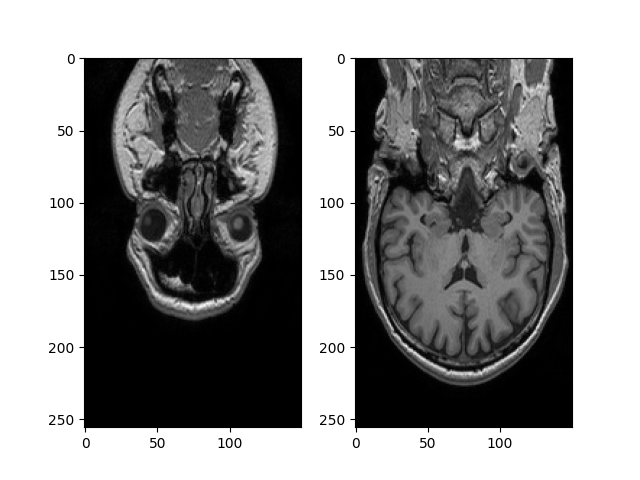

In [12]:
# Coronal View - front to back - face to back
fig, axis = plt.subplots(1, 2)
# front of face
axis[0].imshow(brain_mri_data[40, :, :], cmap="gray")
# middle of face
axis[1].imshow(brain_mri_data[120, :, :], cmap="gray")

# The plot is shifted upwards as the 2nd axis "S" is moving from bottom to top

<IPython.core.display.Javascript object>


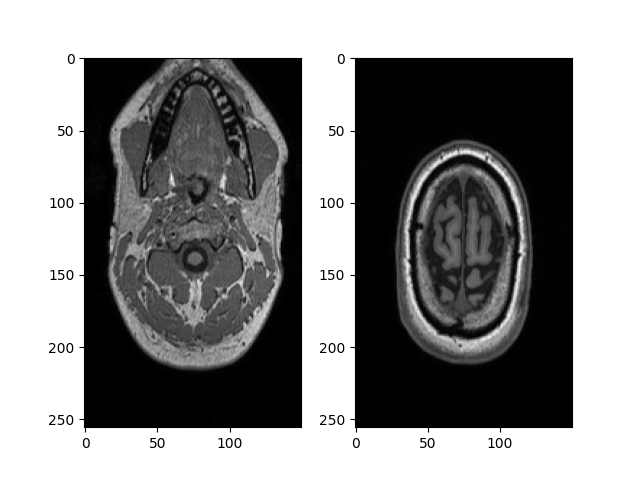

In [7]:
# (Axial View) - slice through 2nd axis bottom to top
fig, axis = plt.subplots(1, 2)
# front of face
axis[0].imshow(brain_mri_data[:, 30, :], cmap="gray")
# middle of face
axis[1].imshow(brain_mri_data[:, 200, :], cmap="gray")


<IPython.core.display.Javascript object>


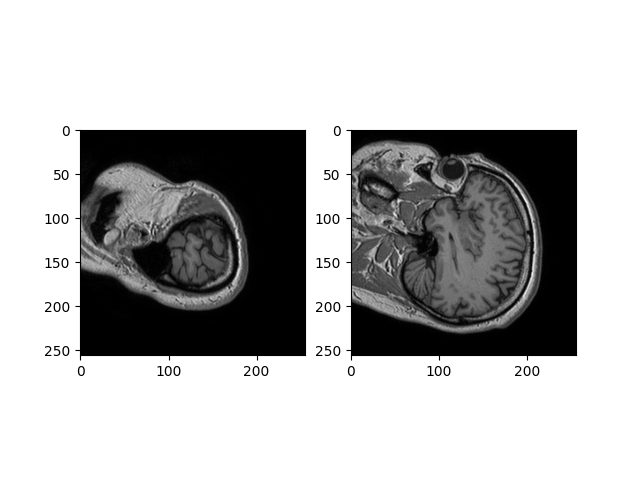

In [8]:
# (Sagittal View) - slice through 2nd axis left to right
fig, axis = plt.subplots(1, 2)
# front of face
axis[0].imshow(brain_mri_data[:, :, 20], cmap="gray")
# middle of face
axis[1].imshow(brain_mri_data[:, :, 45], cmap="gray")

# The head is rotated as the 1st axis "P" is moving from front to back which is y axis in the 
# figure

In [9]:
# voxel coordinates to physical system
# voxel coords are the co-ordinates of the image volumes and physical coords are 
# co-ordinates of the scanner - the physical device
voxel_coords = np.array((0, 0, 0, 1))
physical_coords = affine @ voxel_coords

print(affine.shape)
print(voxel_coords.shape)
print(physical_coords.shape)
print(physical_coords)
print(affine[:, 3:])

(4, 4)
(4,)
(4,)
[ -90.67985535  102.82944489 -114.82378387    1.        ]
[[ -90.67985535]
 [ 102.82944489]
 [-114.82378387]
 [   1.        ]]


In [10]:
voxel_coords_manual = np.array((0, 0, 0))
physical_coords_manual = affine[:3, :3] @ voxel_coords_manual + affine[:3, 3]
physical_coords_manual

array([ -90.67985535,  102.82944489, -114.82378387])

In [11]:
# physical coords to voxel coords
physical_coords = [ -90.67985535,  102.82944489, -114.82378387,    1.        ]
(np.linalg.inv(affine) @ physical_coords).round()

array([-0.,  0., -0.,  1.])

## Resampling

In [15]:
print(brain_mri.shape)

# get_zooms() to get the voxel sizes in millimeters
print(brain_mri.header.get_zooms())

(256, 256, 150)
(0.9375, 0.9375, 1.2000039)


In [16]:
import nibabel.processing

In [20]:
# pixel size of the resized volume
voxel_size = (2, 2, 2)
brain_mri_resized = nibabel.processing.conform(brain_mri, 
                                               (128, 128, 100),
                                               voxel_size, 
                                               orientation="PSR")
brain_mri_resized_data = brain_mri_resized.get_fdata()
print(brain_mri_resized.shape)
print(brain_mri_resized.header.get_zooms())

(128, 128, 100)
(2.0, 2.0, 2.0)


<IPython.core.display.Javascript object>


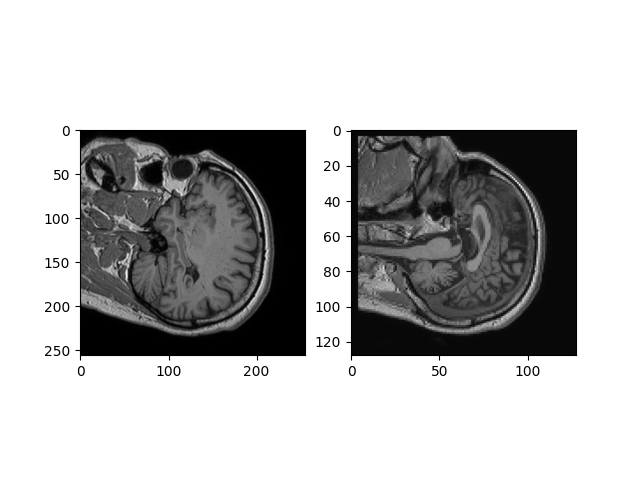

In [21]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_data[:, :, 50], cmap="gray")
axis[1].imshow(brain_mri_resized_data[:, :, 50], cmap="gray")


## Normalization and standardization of CT and MRI

#### CT scans have fixed and absolute scale from -1000 (for air) to +1000 (for water)
#### Dont perform normalization on CT to keep the sacles
#### In practice, we can assume that all world use within a CT scan lie between -1024 and +3071
#### We can standardize the data by scaling the volume with the constant 1/3071


<IPython.core.display.Javascript object>


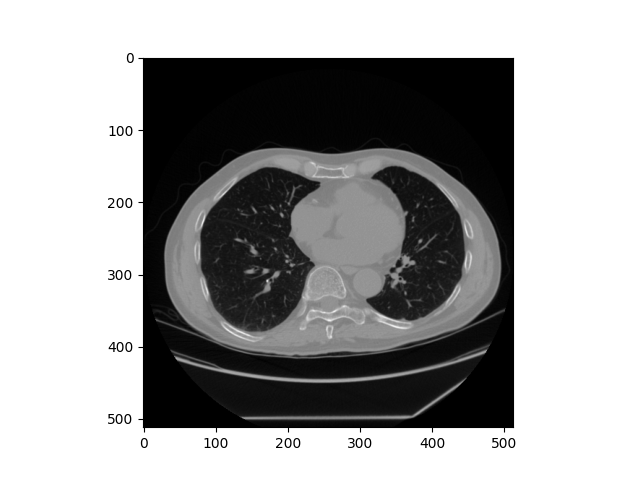

In [27]:
# CT
lung_ct = nib.load("./data/DICOM/Nifti_images/lung_043.nii.gz")
lung_ct_data = lung_ct.get_fdata()
# ## Normalization and standardization of CT and MRI
lung_ct_data_standardized = lung_ct_data/3071
plt.figure()
plt.imshow(np.rot90(lung_ct_data_standardized[:, :, 50]), cmap="gray")

<IPython.core.display.Javascript object>


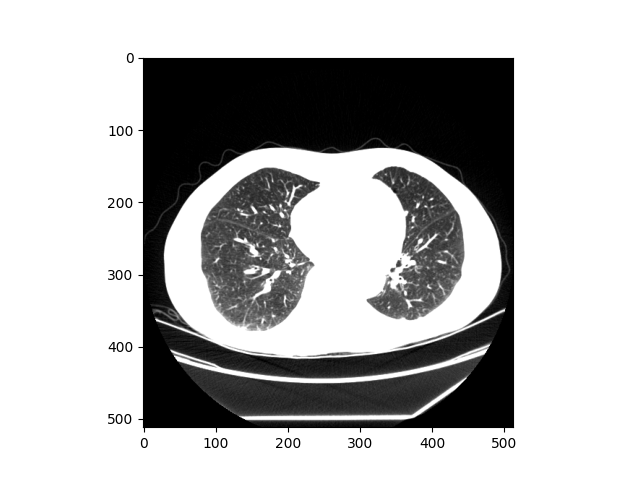

In [28]:
# Windowing
lung_ct_lung_window = np.clip(lung_ct_data, -1000, -500)
plt.figure()
plt.imshow(np.rot90(lung_ct_lung_window[:, :, 50]), cmap="gray")

<IPython.core.display.Javascript object>


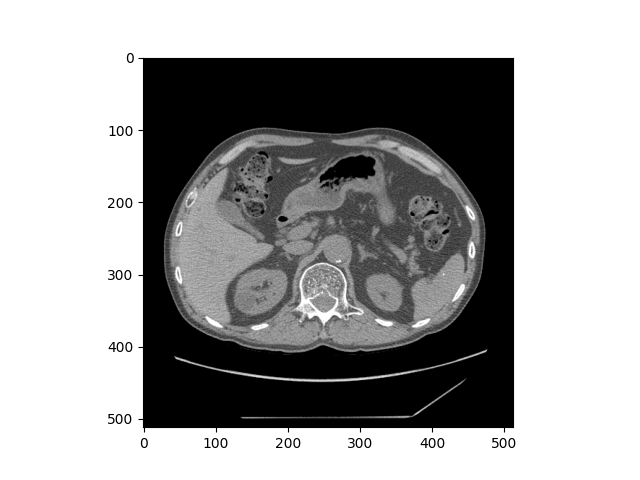

In [31]:
lung_ct_soft_tissue_window = np.clip(lung_ct_data, -250, 250)
plt.figure()
plt.imshow(np.rot90(lung_ct_soft_tissue_window[:, :, 5]), cmap="gray")

In [39]:
# MRI
cardiac_mri = nib.load("./data/DICOM/Nifti_images/la_003.nii.gz")
cardiac_mri_data = cardiac_mri.get_fdata()
# Normalization
mean, std = np.mean(cardiac_mri_data), np.std(cardiac_mri_data)
cardiac_mri_norm = (cardiac_mri_data - mean) / std

# Standardize
cardiac_mri_standardized = (
        cardiac_mri_norm - np.min(cardiac_mri_norm)
                    )/(np.max(cardiac_mri_norm) - np.min(cardiac_mri_norm))


In [42]:
np.mean(cardiac_mri_standardized), np.min(cardiac_mri_standardized), np.max(cardiac_mri_standardized)

(0.08641350659554545, 0.0, 1.0)

<IPython.core.display.Javascript object>


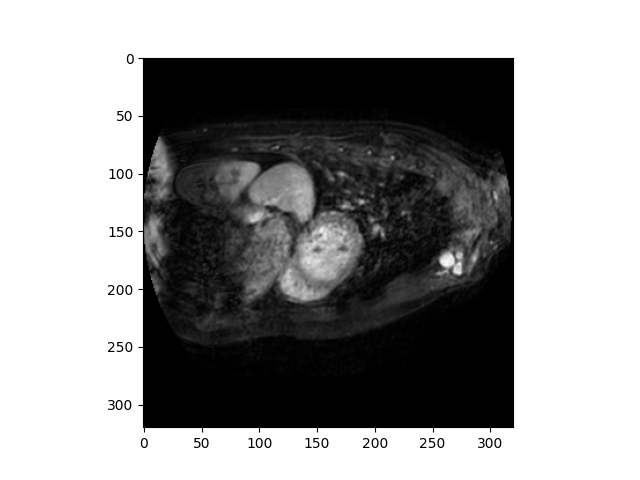

In [45]:
plt.figure()
plt.imshow(cardiac_mri_standardized[:, :, 30], cmap="gray")